<a href="https://colab.research.google.com/github/Ali-Hasan-Khan28/Computer-Vision/blob/main/LabMid2021079.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("start")

start


#MRI Brain Tumor Image Classification

In [41]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler,ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,RMSprop
from sklearn.metrics import accuracy_score, confusion_matrix
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import regularizers
import nibabel as nib
from scipy import ndimage

## Normalization of Images

In [42]:
path_No = '/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/no/*'
path_Yes = '/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (128, 128))
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

array([[[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[1, 1, 1],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [1, 1, 1],
        [1, 1, 1]]], dtype=uint8)
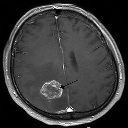

In [120]:
all_data[0][0]

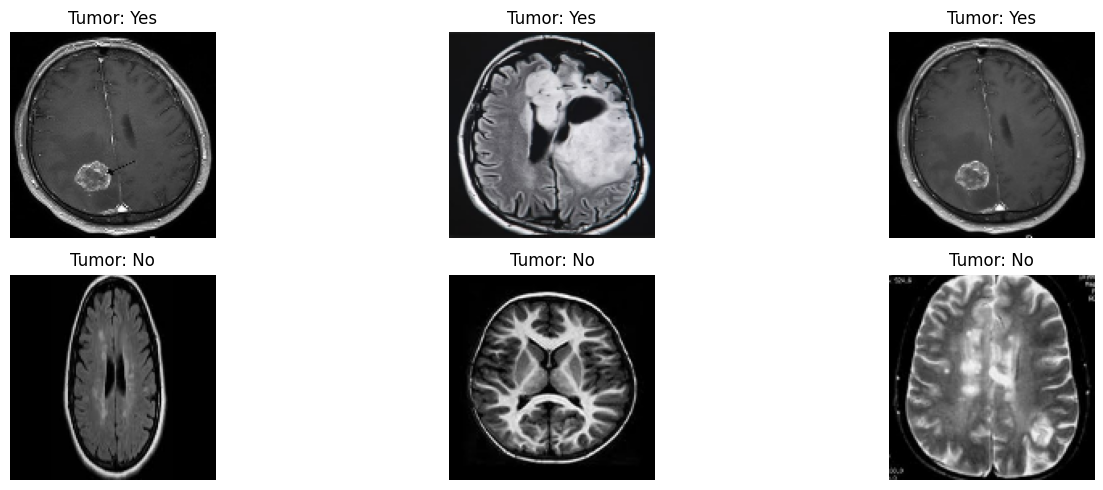

In [43]:
plt.figure(figsize=(15, 5))

# Display tumor images with label 'yes'
for i in range(3):
    plt.subplot(2, 3, i+1)
    plt.imshow(tumor[i][0])
    plt.title("Tumor: Yes")
    plt.axis('off')

# Display no_tumor images with label 'no'
for i in range(3):
    plt.subplot(2, 3, i+4)
    plt.imshow(no_tumor[i][0])
    plt.title("Tumor: No")
    plt.axis('off')

plt.tight_layout()
plt.show()

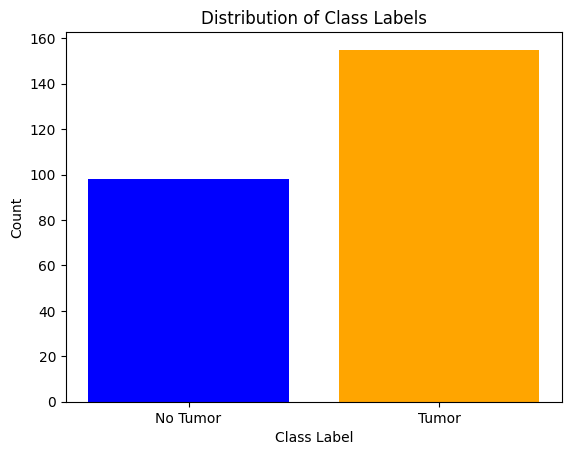

In [44]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()

In [45]:
def crop_brain_region(image, size):

    # Converting the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Applying Gaussian blur to smooth the image and reduce noise
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Thresholding the image to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Performing morphological operations to remove noise
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Finding contours in the binary mask
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Assuming the brain part of the image has the largest contour
    c = max(contours, key=cv2.contourArea)

    # Getting the bounding rectangle of the brain part
    x, y, w, h = cv2.boundingRect(c)

    # Drawing contours on the original image
    contour_image = cv2.drawContours(image.copy(), [c], -1, (0, 255, 0), 2)

    # Drawing bounding box on the original image
    bounding_box_image = cv2.rectangle(image.copy(), (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Cropping the image around the bounding rectangle
    cropped_image = image[y:y+h, x:x+w]

    # Resizing cropped image to the needed size
    resized_image = cv2.resize(cropped_image, size)

    return contour_image, bounding_box_image, cropped_image, resized_image

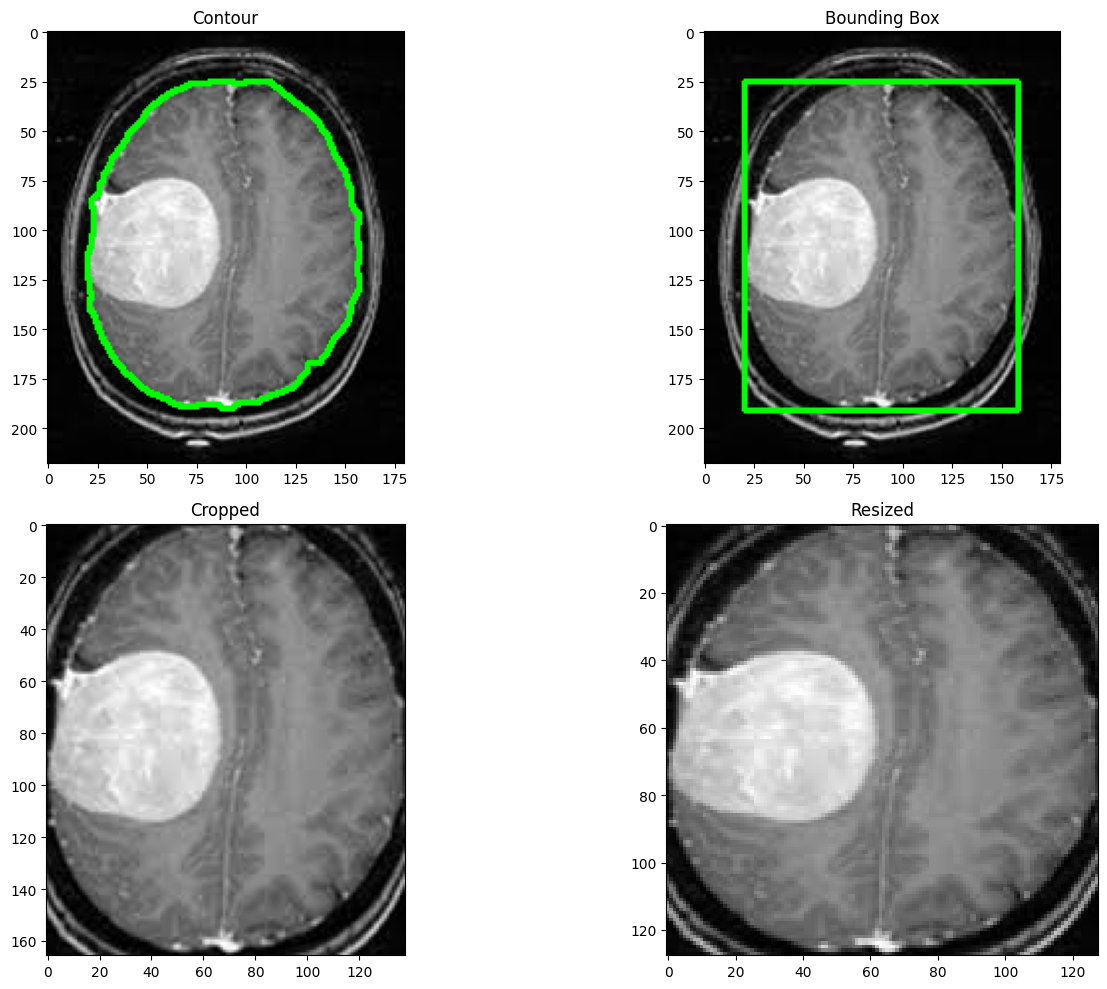

In [46]:
output_size = (128, 128)

example_image = cv2.imread('/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/yes/Y1.jpg')
example_image = cv2.cvtColor(example_image, cv2.COLOR_BGR2RGB)

contour_image, bounding_box_image, cropped_image, resized_image = crop_brain_region(example_image, output_size)


plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.imshow(contour_image)
plt.title("Contour")

plt.subplot(2, 2, 2)
plt.imshow(bounding_box_image)
plt.title("Bounding Box")

plt.subplot(2, 2, 3)
plt.imshow(cropped_image)
plt.title("Cropped")

plt.subplot(2, 2, 4)
plt.imshow(resized_image)
plt.title("Resized")

plt.tight_layout()
plt.show()

all_cropped = []

# Applying the crop function to each one of our images
for image in data:
    _, _, _, resized_image = crop_brain_region(image, output_size)
    all_cropped.append(resized_image)

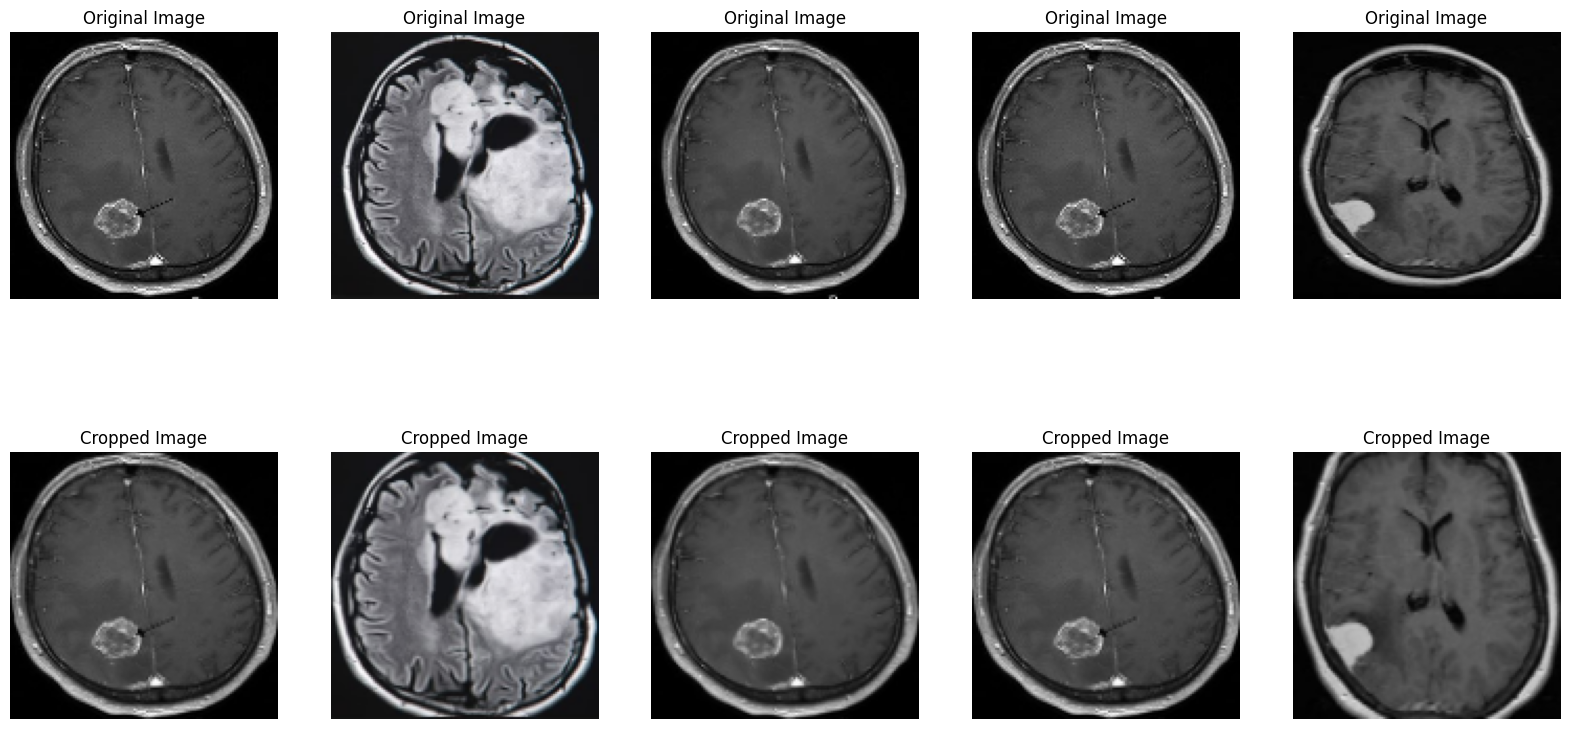

In [47]:
num_images_per_class = 5

class_0_counter = 0
class_1_counter = 0

plt.figure(figsize=(20, 10))

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, i + 1)
    plt.imshow(data[i])
    plt.title("Original Image")
    plt.axis("off")

for i in range(num_images_per_class):
    plt.subplot(2, num_images_per_class, num_images_per_class + i + 1)
    plt.imshow(all_cropped[i])
    plt.title("Cropped Image")
    plt.axis("off")

plt.show()

## Canny Edge Detection of Images

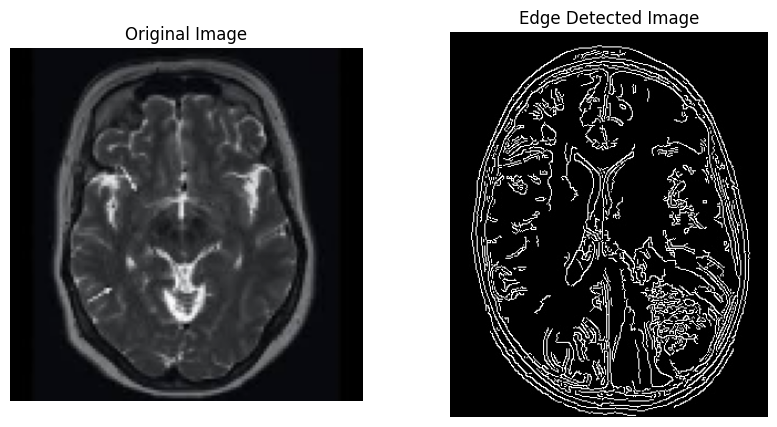

In [48]:
import cv2
import matplotlib.pyplot as plt

def apply_canny_edge_detection(image_path, low_threshold, high_threshold):
    # Read the image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Apply Canny edge detection
    edges = cv2.Canny(image, low_threshold, high_threshold)

    # Display the original image and the edges
    cv2.imwrite("Original_Image.jpg", image)
    cv2.imwrite("Canny_Edges.jpg", edges)

if __name__ == "__main__":
    # Replace "your_image.jpg" with the path to your image
    image_path = "/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/yes/Y100.JPG"

    # Set the threshold values (adjust these based on your image and application)
    low_threshold = 30
    high_threshold = 100

    # Apply Canny edge detection for the single image
    apply_canny_edge_detection(image_path, low_threshold, high_threshold)

    # Read the edge-detected image
    edges = cv2.imread("Canny_Edges.jpg", cv2.IMREAD_GRAYSCALE)

    # Display the original image and the edges
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(edges, cmap='gray')
    plt.title('Edge Detected Image')
    plt.axis('off')
    plt.show()


## Splitting data into train, test and validation sets

In [49]:
all_cropped=np.array(all_cropped)

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)
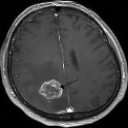

In [105]:
all_cropped[0]

In [50]:
# Shuffling the data to make sure the images are randomized and there is no order in labels
all_cropped_shuffled, labels_shuffled = shuffle(all_cropped, labels, random_state=42)

train_images, test_images, train_labels, test_labels = train_test_split(all_cropped_shuffled, labels_shuffled, test_size=0.2, random_state=42)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size=0.5, random_state=42)

print("Train data shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Validation data shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)
print("Test data shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train data shape: (202, 128, 128, 3)
Train labels shape: (202,)
Validation data shape: (26, 128, 128, 3)
Validation labels shape: (26,)
Test data shape: (25, 128, 128, 3)
Test labels shape: (25,)


In [51]:
print(np.max(train_images))
print(np.min(train_images))

255
0


In [52]:
train_images=train_images/255
test_images=test_images/255
val_images=val_images/255

In [53]:
print(np.max(train_images))
print(np.min(train_images))

1.0
0.0


## Applying a CNN Model

In [54]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=1e-4))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 128)      

In [55]:
epochs = 20
batch_size = 32

early_stopping = EarlyStopping(patience=5, monitor='val_loss')  # Defining early stopping to stop the model from overfitting


history = model.fit(train_images,
                    train_labels,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_images, val_labels),
                   callbacks=[early_stopping])

Epoch 1/20
7/7 [==============================] - 3s 79ms/step - loss: 0.6763 - accuracy: 0.5941 - val_loss: 0.5967 - val_accuracy: 0.6923
Epoch 2/20
7/7 [==============================] - 0s 33ms/step - loss: 0.6604 - accuracy: 0.6089 - val_loss: 0.6098 - val_accuracy: 0.6923
Epoch 3/20
7/7 [==============================] - 0s 31ms/step - loss: 0.6574 - accuracy: 0.6089 - val_loss: 0.6070 - val_accuracy: 0.6923
Epoch 4/20
7/7 [==============================] - 0s 29ms/step - loss: 0.6523 - accuracy: 0.6089 - val_loss: 0.5980 - val_accuracy: 0.6923
Epoch 5/20
7/7 [==============================] - 0s 28ms/step - loss: 0.6432 - accuracy: 0.6040 - val_loss: 0.5959 - val_accuracy: 0.6923
Epoch 6/20
7/7 [==============================] - 0s 24ms/step - loss: 0.6211 - accuracy: 0.6238 - val_loss: 0.5909 - val_accuracy: 0.6923
Epoch 7/20
7/7 [==============================] - 0s 22ms/step - loss: 0.6225 - accuracy: 0.6287 - val_loss: 0.5999 - val_accuracy: 0.6923
Epoch 8/20
7/7 [===========

1/1 [==============================] - 0s 76ms/step
Predictions for validation images
Yes
Yes
No
Yes
No
Yes
Yes
Yes
Yes
No
No
Yes
Yes
No
Yes
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Accuracy on Validation Set: 0.846 %


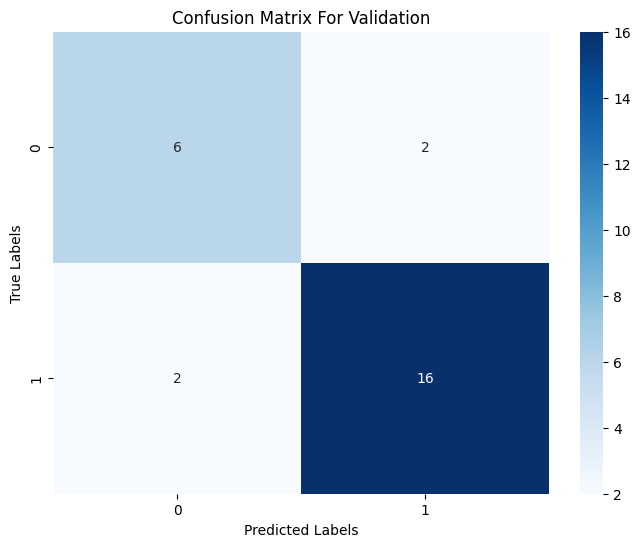

In [56]:
predictions = model.predict(val_images)
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
print("Predictions for validation images")
for i in binary_predictions:
  if i == 0:
    print("No")
  elif i == 1:
    print("Yes")

conf_matrix = confusion_matrix(val_labels, binary_predictions)

accuracy = accuracy_score(val_labels, binary_predictions)
print("Accuracy on Validation Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Validation')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 22ms/step
Predictions for test images
Yes
No
Yes
Yes
No
Yes
Yes
Yes
Yes
No
Yes
No
Yes
No
Yes
No
Yes
Yes
No
Yes
No
Yes
No
No
Yes
Accuracy on Test Set: 0.800 %


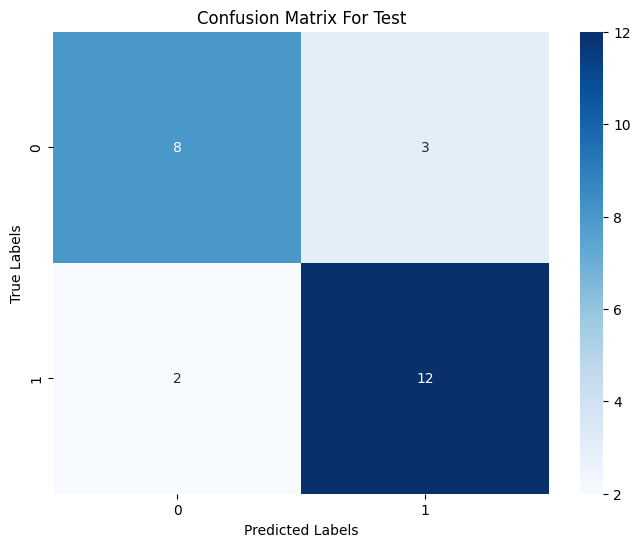

In [57]:
predictions = model.predict(test_images)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
print("Predictions for test images")
for i in binary_predictions:
  if i == 0:
    print("No")
  elif i == 1:
    print("Yes")
conf_matrix = confusion_matrix(test_labels, binary_predictions)

accuracy = accuracy_score(test_labels, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

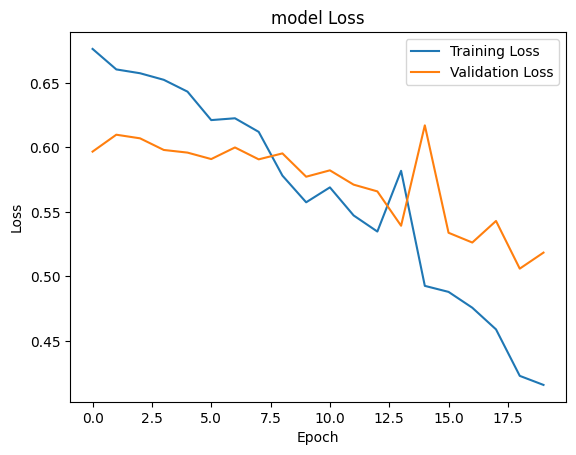

In [58]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

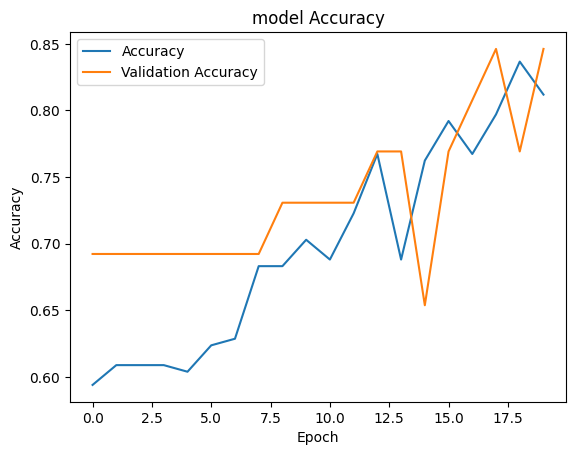

In [59]:
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## MRI classification Using SVM

In [60]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [61]:
Categories=['no','yes']
flat_data_arr=[] #input array
target_arr=[] #output array
datadir='/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/'
#path which contains all the categories of images
for i in Categories:

    print(f'loading... category : {i}')
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
        img_array=imread(os.path.join(path,img))
        img_resized=resize(img_array,(150,150,3))
        flat_data_arr.append(img_resized.flatten())
        target_arr.append(Categories.index(i))
    print(f'loaded category:{i} successfully')
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)

loading... category : no
loaded category:no successfully
loading... category : yes
loaded category:yes successfully


Creating a target colunm for evaluation

In [62]:
df=pd.DataFrame(flat_data)
df['Target']=target
df.shape

(253, 67501)

Drop some rows because model.fit is taking so much time

In [63]:
# for i in range(len(df)):
#   if i%2!=0:
#     df.drop(i, axis=0, inplace=True)

# len(df)

In [64]:
#input data
x=df.iloc[:,:-1]
#output data
y=df.iloc[:,-1]

In [65]:
# Splitting the data into training and testing sets
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,
                                               random_state=77,
                                               stratify=y)

In [66]:
from sklearn.svm import SVC

In [67]:
svm_classifier = SVC()

# Train the model on the training data
svm_classifier.fit(x_train, y_train)

# Make predictions on the testing data
svm_predictions = svm_classifier.predict(x_test)

# Calculate the accuracy of the model
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Classifier Accuracy:", svm_accuracy)


SVM Classifier Accuracy: 0.7254901960784313


Predictions for test images
No
Yes
Yes
No
Yes
No
Yes
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
No
No
Yes
Yes
No
Yes
Yes
No
No
Yes
No
No
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Accuracy on Test Set: 0.725 %


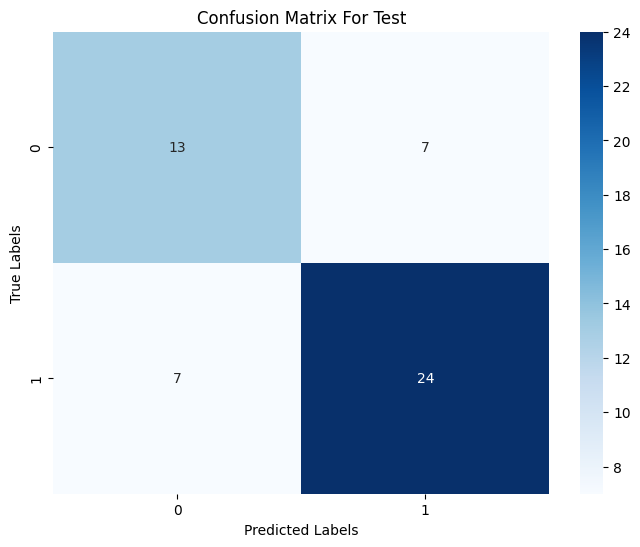

In [68]:
predictions = svm_classifier.predict(x_test)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
print("Predictions for test images")
for i in binary_predictions:
  if i == 0:
    print("No")
  elif i == 1:
    print("Yes")
conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [70]:
# path='/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/yes/Y106.jpg'
# img=imread(path)
# plt.imshow(img)
# plt.show()
# img_resize=resize(img,(150,150,3))
# l=[img_resize.flatten()]
# probability=model.predict_proba(l)
# for ind,val in enumerate(Categories):
#     print(f'{val} = {probability[0][ind]*100}%')
# print("The predicted image is : "+Categories[model.predict(l)[0]])

## MRI classification Using Random Forest

In [71]:
from sklearn.ensemble import RandomForestClassifier
import sklearn

In [72]:
rf = RandomForestClassifier()

rf.fit(x_train,y_train)
# Predictions on training and validation
y_pred_train = rf.predict(x_train)
    # predictions for test
y_pred_test = rf.predict(x_test)
    # training metrics
print("Training metrics:")
print(sklearn.metrics.classification_report(y_true= y_train, y_pred= y_pred_train))

    # test data metrics
print("Test data metrics:")
print(sklearn.metrics.classification_report(y_true= y_test, y_pred= y_pred_test))
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Training metrics:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        78
           1       1.00      1.00      1.00       124

    accuracy                           1.00       202
   macro avg       1.00      1.00      1.00       202
weighted avg       1.00      1.00      1.00       202

Test data metrics:
              precision    recall  f1-score   support

           0       0.83      0.75      0.79        20
           1       0.85      0.90      0.88        31

    accuracy                           0.84        51
   macro avg       0.84      0.83      0.83        51
weighted avg       0.84      0.84      0.84        51

Accuracy: 0.7254901960784313


Predictions for test images
No
Yes
Yes
No
Yes
No
No
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
Yes
No
Yes
Yes
Yes
No
Yes
No
No
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Accuracy on Test Set: 0.843 %


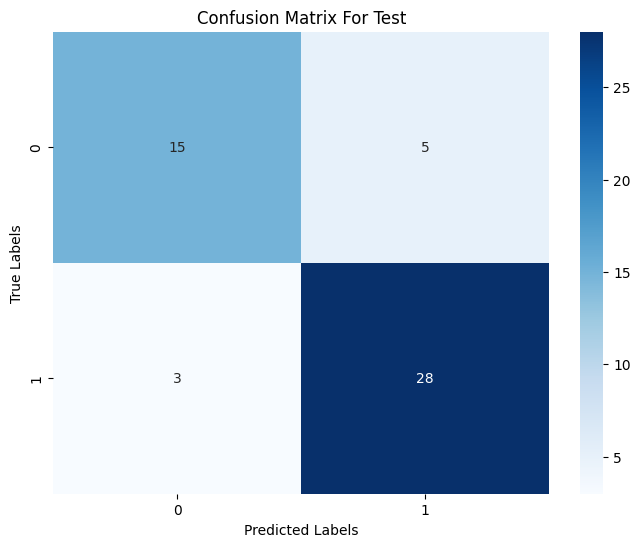

In [73]:
predictions = rf.predict(x_test)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
print("Predictions for test images")
for i in binary_predictions:
  if i == 0:
    print("No")
  elif i == 1:
    print("Yes")
conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## MRI Classification using Logistic Regression


In [74]:
from cv2 import ml
from numpy import float32

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Splitting the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(flat_data, target, test_size=0.20,
                                                    random_state=77,
                                                    stratify=target)

# Initialize the logistic regression model
logistic_regression_model = LogisticRegression()

# Train the model on the training data
logistic_regression_model.fit(x_train, y_train)

# Make predictions on the testing data
predictions = logistic_regression_model.predict(x_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.803921568627451


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Predictions for test images
No
Yes
Yes
No
Yes
No
No
No
No
No
No
Yes
No
No
Yes
No
Yes
No
Yes
Yes
No
No
Yes
Yes
Yes
Yes
Yes
Yes
Yes
Yes
No
Yes
No
Yes
No
No
Yes
Yes
Yes
Yes
Yes
No
No
Yes
No
Yes
No
Yes
Yes
Yes
Yes
Accuracy on Test Set: 0.804 %


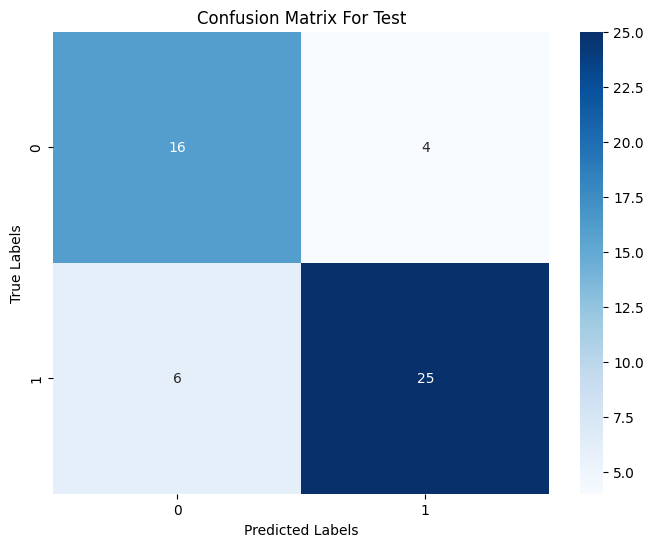

In [76]:
predictions = logistic_regression_model.predict(x_test)

threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
print("Predictions for test images")
for i in binary_predictions:
  if i == 0:
    print("No")
  elif i == 1:
    print("Yes")
conf_matrix = confusion_matrix(y_test, binary_predictions)

accuracy = accuracy_score(y_test, binary_predictions)
print("Accuracy on Test Set: {:.3f} %".format(accuracy))

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix For Test')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Now Implementing Model Pipeline to classifiy images based on CNN Model as it has highest Accuracy of 84%

In [138]:
filen = "/content/drive/MyDrive/Colab_Notebooks/Computer Vision Lab/brain_tumor_dataset/yes/Y10.jpg"

In [139]:
output_size = (128, 128)

In [140]:
img = cv2.imread(filen)      #Reading the images from the path
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
img = cv2.resize(img, (128, 128))

array([[[255, 255, 255],
        [251, 251, 251],
        [248, 248, 248],
        ...,
        [248, 248, 248],
        [246, 246, 246],
        [249, 249, 249]],

       [[242, 242, 242],
        [ 99,  99,  99],
        [ 44,  44,  44],
        ...,
        [ 50,  50,  50],
        [ 98,  98,  98],
        [253, 253, 253]],

       [[250, 250, 250],
        [ 78,  78,  78],
        [ 29,  29,  29],
        ...,
        [ 23,  23,  23],
        [ 82,  82,  82],
        [245, 245, 245]],

       ...,

       [[250, 250, 250],
        [ 78,  78,  78],
        [ 29,  29,  29],
        ...,
        [ 20,  20,  20],
        [ 81,  81,  81],
        [247, 247, 247]],

       [[242, 242, 242],
        [ 99,  99,  99],
        [ 44,  44,  44],
        ...,
        [ 47,  47,  47],
        [ 97,  97,  97],
        [254, 254, 254]],

       [[255, 255, 255],
        [251, 251, 251],
        [248, 248, 248],
        ...,
        [245, 245, 245],
        [245, 245, 245],
        [251, 251, 251]]], dtype=uint8)
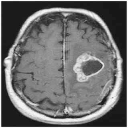

In [141]:
img

array([255, 255, 255], dtype=uint8)

In [142]:
img = np.array(img)

In [143]:
_, _, _, resized_image = crop_brain_region(img, output_size)

In [144]:
resized_image = np.array(resized_image)

In [145]:
resized_image=resized_image/255

In [146]:
print(resized_image)

[[[1.         1.         1.        ]
  [0.98431373 0.98431373 0.98431373]
  [0.97254902 0.97254902 0.97254902]
  ...
  [0.96470588 0.96470588 0.96470588]
  [0.96470588 0.96470588 0.96470588]
  [0.96470588 0.96470588 0.96470588]]

 [[0.94901961 0.94901961 0.94901961]
  [0.41568627 0.41568627 0.41568627]
  [0.18823529 0.18823529 0.18823529]
  ...
  [0.19215686 0.19215686 0.19215686]
  [0.19215686 0.19215686 0.19215686]
  [0.19215686 0.19215686 0.19215686]]

 [[0.98039216 0.98039216 0.98039216]
  [0.3372549  0.3372549  0.3372549 ]
  [0.12941176 0.12941176 0.12941176]
  ...
  [0.10196078 0.10196078 0.10196078]
  [0.10196078 0.10196078 0.10196078]
  [0.10196078 0.10196078 0.10196078]]

 ...

 [[0.98039216 0.98039216 0.98039216]
  [0.3372549  0.3372549  0.3372549 ]
  [0.12941176 0.12941176 0.12941176]
  ...
  [0.09803922 0.09803922 0.09803922]
  [0.09803922 0.09803922 0.09803922]
  [0.09803922 0.09803922 0.09803922]]

 [[0.94901961 0.94901961 0.94901961]
  [0.41568627 0.41568627 0.41568627]


In [147]:
np.max(resized_image)

1.0

In [ ]:
predictions = model.predict(resized_image)

All part is complted just change the path in above 138 line as input and get accurate output
Jazak Allah